In [1]:
a=2
print(a)

2


In [2]:
from casadi import *

T = 10. # Time horizon
N = 20 # number of control intervals

# Declare model variables
x1 = MX.sym('x1')
x2 = MX.sym('x2')
x = vertcat(x1, x2)
u = MX.sym('u')

# Model equations
xdot = vertcat((1-x2**2)*x1 - x2 + u, x1)

# Objective term
L = x1**2 + x2**2 + u**2

# Formulate discrete time dynamics
if False:
   # CVODES from the SUNDIALS suite
   dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
   opts = {'tf':T/N}
   F = integrator('F', 'cvodes', dae, opts)
else:
   # Fixed step Runge-Kutta 4 integrator
   M = 4 # RK4 steps per interval
   DT = T/N/M
   f = Function('f', [x, u], [xdot, L])
   X0 = MX.sym('X0', 2)
   U = MX.sym('U')
   X = X0
   Q = 0
   for j in range(M):
       k1, k1_q = f(X, U)
       k2, k2_q = f(X + DT/2 * k1, U)
       k3, k3_q = f(X + DT/2 * k2, U)
       k4, k4_q = f(X + DT * k3, U)
       X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
       Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
   F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])
print(f)
print(X)
print(F)

f:(i0[2],i1)->(o0[2],o1) MXFunction
@1=f(X0, U){0}, @2=f((X0+(0.0625*@1)), U){0}, @3=f((X0+(0.0625*@2)), U){0}, @4=(X0+(0.0208333*(((@1+(2.*@2))+(2.*@3))+f((X0+(0.125*@3)), U){0}))), @5=f(@4, U){0}, @6=f((@4+(0.0625*@5)), U){0}, @7=f((@4+(0.0625*@6)), U){0}, @8=(@4+(0.0208333*(((@5+(2.*@6))+(2.*@7))+f((@4+(0.125*@7)), U){0}))), @9=f(@8, U){0}, @10=f((@8+(0.0625*@9)), U){0}, @11=f((@8+(0.0625*@10)), U){0}, @12=(@8+(0.0208333*(((@9+(2.*@10))+(2.*@11))+f((@8+(0.125*@11)), U){0}))), @13=f(@12, U){0}, @14=f((@12+(0.0625*@13)), U){0}, @15=f((@12+(0.0625*@14)), U){0}, (@12+(0.0208333*(((@13+(2.*@14))+(2.*@15))+f((@12+(0.125*@15)), U){0})))
F:(x0[2],p)->(xf[2],qf) MXFunction


In [3]:
from casadi import *

# Declare model variables
x = MX.sym('x')
# x1 = MX.sym('x1')
# x2 = MX.sym('x2')
# x = vertcat(x1, x2)
u = MX.sym('u')
A = MX.sym('A')
B = MX.sym('B')
DT = MX.sym('DT')

# Model equations
# xdot = vertcat((1-x2**2)*x1 - x2 + u, x1)
xdot = mtimes(A,x) + mtimes(B,u)
f = Function('f', [x, u], [xdot])

# Fixed step Runge-Kutta 4 integrator
M = 4 # RK4 steps per interval
X = MX.sym('X_k')
U = MX.sym('u')

# for j in range(M):
k1  = f(X, U)
k2  = f(X + DT/2 * k1, U)
k3  = f(X + DT/2 * k2, U)
k4  = f(X + DT * k3, U)
X=X+DT/6*(k1 +2*k2 +2*k3 +k4)

print(X)

@1=((A*X_k)+(B*u)), @2=((A*(X_k+((DT/2)*@1)))+(B*u)), @3=((A*(X_k+((DT/2)*@2)))+(B*u)), (X_k+((DT/6)*(((@1+(2.*@2))+(2.*@3))+((A*(X_k+(DT*@3)))+(B*u)))))


In [4]:
from sympy import *

X_k = Symbol('x_k')
u = Symbol('u')
A = Symbol('A')
B = Symbol('B')
DT = Symbol('dT')

k1 = ((A*X_k)+(B*u))
k2 = ((A*(X_k+((DT/2)*k1)))+(B*u))
k3 = ((A*(X_k+((DT/2)*k2)))+(B*u))
k4 = A*(X_k + DT * k3) + B*u
xkk = X_k + DT/6*(k1 +2*k2 +2*k3 +k4)
print(xkk)

simplify(xkk)
# collect(xkk, X_k)



dT*(A*x_k + 2*A*(dT*(A*x_k + B*u)/2 + x_k) + 2*A*(dT*(A*(dT*(A*x_k + B*u)/2 + x_k) + B*u)/2 + x_k) + A*(dT*(A*(dT*(A*(dT*(A*x_k + B*u)/2 + x_k) + B*u)/2 + x_k) + B*u) + x_k) + 6*B*u)/6 + x_k


A**4*dT**4*x_k/24 + A**3*B*dT**4*u/24 + A**3*dT**3*x_k/6 + A**2*B*dT**3*u/6 + A**2*dT**2*x_k/2 + A*B*dT**2*u/2 + A*dT*x_k + B*dT*u + x_k

In [5]:
from sympy import *

x = Symbol('x')
u = Symbol('u')
A = Symbol('A')
B = Symbol('B')
C = Symbol('C')
DT = Symbol('dT')
X_k = Symbol('x_k')
u_k = Symbol('u_k')

f = A*x + B*u + C

# k1  = f(X, U)
# k2  = f(X + DT/2 * k1, U)
# k3  = f(X + DT/2 * k2, U)
# k4  = f(X + DT * k3, U)
# X=X+DT/6*(k1 +2*k2 +2*k3 +k4)

k1 = f.evalf(subs = {x:X_k, u:u_k})
k2 = f.evalf(subs = {x:(X_k + 0.5*DT*k1), u:u_k})
k3 = f.evalf(subs = {x:(X_k + 0.5*DT*k2), u:u_k})
k4 = f.evalf(subs = {x:(X_k + DT*k3), u:u_k})
xkk = X_k + DT/6*(k1 +2*k2 +2*k3 +k4)
print(1/24.0)
print(1/6.0)
print(xkk)
simplify(xkk)
expand(xkk)
# simplify(expand(xkk))
# collect(xkk, X_k)


0.041666666666666664
0.16666666666666666
dT*(A*x_k + 2*A*(0.5*dT*(A*x_k + B*u_k + C) + x_k) + 2*A*(0.5*dT*(A*(0.5*dT*(A*x_k + B*u_k + C) + x_k) + B*u_k + C) + x_k) + A*(dT*(A*(0.5*dT*(A*(0.5*dT*(A*x_k + B*u_k + C) + x_k) + B*u_k + C) + x_k) + B*u_k + C) + x_k) + 6*B*u_k + 6*C)/6 + x_k


0.0416666666666667*A**4*dT**4*x_k + 0.0416666666666667*A**3*B*dT**4*u_k + 0.0416666666666667*A**3*C*dT**4 + 0.166666666666667*A**3*dT**3*x_k + 0.166666666666667*A**2*B*dT**3*u_k + 0.166666666666667*A**2*C*dT**3 + 0.5*A**2*dT**2*x_k + 0.5*A*B*dT**2*u_k + 0.5*A*C*dT**2 + A*dT*x_k + B*dT*u_k + C*dT + x_k

In [6]:
from sympy import MatrixSymbol, Matrix, Symbol, expand
U = MatrixSymbol('U', 3, 1)
U0 = MatrixSymbol('U_0', 3, 1)
A = MatrixSymbol('A', 3, 3)
R = MatrixSymbol('R_udot', 3, 3)
dt = Symbol('d_t')
Udt = (A*U-U0)/dt
y = (Udt).T*R*(Udt)
expand(y)

(-1/d_t**2)*U.T*A.T*R_udot*U_0 + (-1/d_t**2)*U_0.T*R_udot*A*U + d_t**(-2)*U.T*A.T*R_udot*A*U + d_t**(-2)*U_0.T*R_udot*U_0

In [7]:
from sympy import MatrixSymbol, Matrix, Symbol, expand
U = MatrixSymbol('U', 3, 1)
U0 = MatrixSymbol('U_0', 3, 1)
A = MatrixSymbol('A', 3, 3)
R = MatrixSymbol('R_udot', 3, 3)
dt = Symbol('d_t')
Udt = A/dt*U-U0
y = (Udt).T*R*(Udt)
expand(y)

(-1/d_t)*U.T*A.T*R_udot*U_0 + (-1/d_t)*U_0.T*R_udot*A*U + U_0.T*R_udot*U_0 + d_t**(-2)*U.T*A.T*R_udot*A*U

In [8]:
from sympy import MatrixSymbol, Matrix, Symbol, expand
U = MatrixSymbol('U', 3, 1)
U0 = MatrixSymbol('U_0', 3, 1)
A = MatrixSymbol('A', 3, 3)
R = MatrixSymbol('R_udot', 3, 3)
dt = Symbol('d_t')
Udt = A/dt*U-U0/dt
y = (Udt).T*R*(Udt)
expand(y)

(-1/d_t**2)*U.T*A.T*R_udot*U_0 + (-1/d_t**2)*U_0.T*R_udot*A*U + d_t**(-2)*U.T*A.T*R_udot*A*U + d_t**(-2)*U_0.T*R_udot*U_0

In [9]:
from sympy import MatrixSymbol, Matrix, Symbol, expand
xn = MatrixSymbol('x_n', 3, 1)
xr = MatrixSymbol('x_r', 3, 1)
Q = MatrixSymbol('Q', 3, 3)
# dt = Symbol('d_t')
x = xn-xr
y = (x).T*Q*(x)
expand(y)

x_n.T*Q*x_n - x_n.T*Q*x_r - x_r.T*Q*x_n + x_r.T*Q*x_r

In [10]:
from sympy import *

# x = MatrixSymbol('x', 2, 1)
# u = MatrixSymbol('u', 1, 1)
# x = Symbol('x')
# u = Symbol('u')
# a = Symbol('A')
# b = Symbol('B')
# c = Symbol('C')
# f = a*x + b*u + c

A = MatrixSymbol('A', 2, 2)
B = MatrixSymbol('B', 2, 1)
C = MatrixSymbol('C', 2, 1)
DT = Symbol('d_t')
X_k = MatrixSymbol('x_k', 2, 1)
U = MatrixSymbol('u_k', 1, 1)

# k1  = f(X, U)
# k2  = f(X + DT/2 * k1, U)
# k3  = f(X + DT/2 * k2, U)
# k4  = f(X + DT * k3, U)
# X=X+DT/6*(k1 +2*k2 +2*k3 +k4)

k1  = A*X_k + B*U + C
k2  = A*(X_k + 0.5 * DT * k1) + B*U + C
k3  = A*(X_k + 0.5 * DT * k2) + B*U + C
k4  = A*(X_k + DT * k3) + B*U + C
X_k1 = X_k + DT / 6 * (k1 +2*k2 +2*k3 +k4)

# k1 = f.evalf(subs = {x:X_k, u:u_k, a:A, b:B, c:C})
# k2 = f.evalf(subs = {x:(X_k + 0.5*DT*k1), u:u_k})
# k3 = f.evalf(subs = {x:(X_k + 0.5*DT*k2), u:u_k})
# k4 = f.evalf(subs = {x:(X_k + DT*k3), u:u_k})
# xkk = X_k + DT/6*(k1 +2*k2 +2*k3 +k4)
print(1/24.0)
print(1/12.0)
print(1/6.0)
print(X_k1)
simplify(X_k1)
expand(X_k1)
# pprint_use_unicode(True)
# pprint(expand(X_k1))
# print('-'*10)
# expand(exp(A*DT))

0.041666666666666664
0.08333333333333333
0.16666666666666666
(d_t/6)*(2*A*((0.5*d_t)*(A*((0.5*d_t)*(A*x_k + B*u_k + C) + x_k) + B*u_k + C) + x_k) + 2*A*((0.5*d_t)*(A*x_k + B*u_k + C) + x_k) + A*(d_t*(A*((0.5*d_t)*(A*((0.5*d_t)*(A*x_k + B*u_k + C) + x_k) + B*u_k + C) + x_k) + B*u_k + C) + x_k) + A*x_k + 6*B*u_k + 6*C) + x_k


d_t*A*x_k + d_t*B*u_k + d_t*C + (0.5*d_t**2)*A**2*x_k + (0.5*d_t**2)*A*B*u_k + (0.5*d_t**2)*A*C + (0.166666666666667*d_t**3)*A**2*B*u_k + (0.166666666666667*d_t**3)*A**2*C + (0.166666666666667*d_t**3)*A**3*x_k + (0.0416666666666667*d_t**4)*A**3*B*u_k + (0.0416666666666667*d_t**4)*A**3*C + (0.0416666666666667*d_t**4)*A**4*x_k + x_k

In [11]:
ans = 3/(1/57.3)**2
print(ans)


9849.869999999999


15.391723899462022


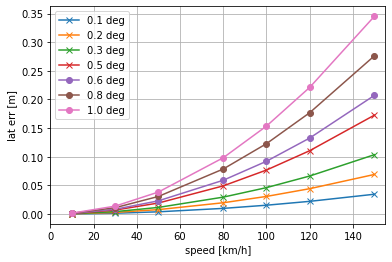

In [12]:
from math import tan, cos, sin

delta_YY = []
delta_angle_err = [0.1, 0.2, 0.3, 0.5, 0.6, 0.8, 1.0]
for steer_angle in delta_angle_err:
    L = 3.005
    # steer_angle = 0.6 # steer angle deg
    R = L / tan(steer_angle / 57.3 / 14.6)
    spd = [10, 30, 50, 80, 100, 120, 150] #range(10, 150, 10)
    t = 1.0
    delta_Y = []
    for v in spd: 
        delta_y = R * (1-cos((v/3.6)*t/R))
        delta_Y.append(delta_y)
    # print(delta_Y)
    delta_YY.append(delta_Y)

steer_angle_err = 0.3
steer_angle_base = 7 # steer angle deg
delta_r = L / ((sin(steer_angle_base/57.3/14.6))**2) * (steer_angle_err/57.3/14.6)
print(delta_r)

import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.array(spd), np.array(delta_YY[0]),"x-", label='0.1 deg')
ax.plot(np.array(spd), np.array(delta_YY[1]),"x-", label='0.2 deg')
ax.plot(np.array(spd), np.array(delta_YY[2]),"x-", label='0.3 deg')
ax.plot(np.array(spd), np.array(delta_YY[3]),"x-", label='0.5 deg')
ax.plot(np.array(spd), np.array(delta_YY[4]),"o-", label='0.6 deg')
ax.plot(np.array(spd), np.array(delta_YY[5]),"o-", label='0.8 deg')
ax.plot(np.array(spd), np.array(delta_YY[6]),"o-", label='1.0 deg')

ax.set_xlabel('speed [km/h]')
ax.set_ylabel('lat err [m]')
ax.set_xlim([0, 155])
plt.grid()
ax.legend()
plt.show()

In [13]:
from math import tan, cos, sin
L = 3.005
steer_angle = 7/57.3
R = L / tan(steer_angle / 14.6)
print(R)

359.12346147174725


In [14]:

from math import tan, cos, sin, atan
ans = atan(0.2/5)
print(ans*57.3)

l = 5*tan(0.5/57.3)
print(l)


2.2907787721645194
0.043631124861199785


In [15]:
bag_file = r"/home/zhiyuan/Downloads/rosbag2_stiffness_1ms2/rosbag2_stiffness_1ms2/rosbag2_2022_03_29-13_14_53/rosbag2_2022_03_29-13_14_53_0.db3"
files = bag_file.split(r"/")
# print(files)
# print(files[-1])
# data_file = ''
data_file = files[-1]
data_file = data_file.replace("rosbag2", "zk580")
data_file = data_file.replace("db3", "npz")
print(data_file)


zk580_2022_03_29-13_14_53_0.npz
